### Predictive Maintenance: Predicting Equipment Failure

In [1]:
#importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#loading the dataset
df = pd.read_csv('predictive_maintenance.csv')
pd.set_option('display.max_columns', None)

In [3]:
#inspecting the dataset
df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure


Variables:
<li> UID: unique identifier ranging from 1 to 10000
<li> product ID: consisting of a letter L, M, or H for low (50% of all products), medium (30%) and high (20%) as  
     product quality variants and a variant-specific serial number
<li> air temperature (K): generated using a random walk process later normalized to a standard deviation of 2K around      300K
<li> process temperature (K): generated using a random walk process normalized to a standard deviation of 1K, added to      the air temperature plus 10K.
<li> rotational speed (rpm): calculated from a power of 2860 W, overlaid with a normally distributed noise
<li> torque (Nm): torque values are normally distributed around 40 Nm with a Ïƒ = 10 Nm and no negative values. 
<li> tool wear (min): The quality variants H/M/L add 5/3/2 minutes of tool wear to the used tool in the process. and a
     'machine failure' label that indicates, whether the machine has failed in this particular datapoint for any of        the following failure modes are true.
<li> Machine failure: label that indicates, whether the machine has failed in this particular data point for any of        the following failure modes are true. The machine failure consists of five independent failure modes:
    <ul>
    <li> tool wear failure (TWF): the tool will be replaced of fail at a randomly selected tool wear time between 200          - 240 mins;
    <li> heat dissipation failure (HDF): heat dissipation causes a process failure, if the difference between air- and          process temperature is below 8.6 K and the tools rotational speed is below 1380 rpm;
    <li> power failure (PWF):the product of torque and rotational speed (in rad/s) equals the power required for the            process. If this power is below 3500 W or above 9000 W, the process fails;
    <li> overstrain failure (OSF): if the product of tool wear and torque exceeds 11,000 minNm for the L product                variant (12,000 M, 13,000 H), the process fails due to overstrain;
    <li> random failures (RNF): each process has a chance of 0,1 % to fail regardless of its process parameters. If at          least one of the above failure modes is true, the process fails and the ’machine failure’ label is set to 1.          It is therefore not transparent to the machine learning method, which of the failure modes has caused the              process to fail.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Target                   10000 non-null  int64  
 9   Failure Type             10000 non-null  object 
dtypes: float64(3), int64(4), object(3)
memory usage: 781.4+ KB


In [5]:
#inspecting the product ID column
df['Product ID'].unique().shape

(10000,)

In [6]:
#UID and Product ID are just unique identifiers so they can be dropped
df.drop(['UDI', 'Product ID'], axis=1, inplace=True)

In [7]:
#converting the int64 Dtype numeric features to float64 for consistency
df['Rotational speed [rpm]'] = df['Rotational speed [rpm]'].astype('float64')
df['Tool wear [min]'] = df['Tool wear [min]'].astype('float64')

In [8]:
df.columns

Index(['Type', 'Air temperature [K]', 'Process temperature [K]',
       'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]', 'Target',
       'Failure Type'],
      dtype='object')

In [9]:
#renaming columns
df.rename(columns={'Type': 'type',
                   'Air temperature [K]': 'air_temp', 
                   'Process temperature [K]': 'process_temp', 
                   'Rotational speed [rpm]': 'rotational_speed', 
                   'Torque [Nm]': 'torque',
                   'Tool wear [min]': 'tool_wear', 
                   'Target': 'target', 
                   'Failure Type': 'failure_type'}, inplace=True)

In [10]:
#inspecting the failure_type column
df['failure_type'].unique()

array(['No Failure', 'Power Failure', 'Tool Wear Failure',
       'Overstrain Failure', 'Random Failures',
       'Heat Dissipation Failure'], dtype=object)

In [11]:
#inspecting the random failures in the failure_type column
df[df['failure_type'] == 'Random Failures'] [['target', 'failure_type']]

,target,failure_type
1221,0,Random Failures
1302,0,Random Failures
1748,0,Random Failures
2072,0,Random Failures
2559,0,Random Failures
3065,0,Random Failures
3452,0,Random Failures
5471,0,Random Failures
5489,0,Random Failures
5495,0,Random Failures


In [12]:
#as seen above the target is listed as 0 even though there was a failure. However, since these are only 18/10000 
#and random failures, these can be dropped from the dataset
to_drop_randfail = df[df['failure_type'] == 'Random Failures'].index

In [13]:
df.drop(to_drop_randfail, inplace = True)

In [14]:
#inspecting the no failure types
df[df['failure_type'] == 'No Failure'] [['target', 'failure_type']].value_counts()

target  failure_type
0       No Failure      9643
1       No Failure         9
dtype: int64

In [15]:
#from above, even though there is no failure, the target was set to 1. These will be removed as it is not clear
#if there was failure or not. In addition, these make up a very small pct of the data
to_drop_nofail = df.loc[(df['failure_type'] == 'No Failure') & (df['target'] == 1)].index

In [16]:
df.drop(to_drop_nofail, inplace=True)

In [17]:
#creating the features and target
features = [col for col in df.columns if df[col].dtype == 'float64' or col == 'type']
target = ['target', 'failure_type']

In [18]:
#inspecting for outliers
df.describe()

,air_temp,process_temp,rotational_speed,torque,tool_wear,target
count,9973.000000,9973.000000,9973.000000,9973.000000,9973.000000,9973.000000
mean,300.003259,310.004031,1538.893212,39.978993,107.921087,0.033089
std,2.000548,1.483692,179.412171,9.966805,63.649152,0.178879
min,295.300000,305.700000,1168.000000,3.800000,0.000000,0.000000
25%,298.300000,308.800000,1423.000000,33.200000,53.000000,0.000000
50%,300.100000,310.100000,1503.000000,40.100000,108.000000,0.000000
75%,301.500000,311.100000,1612.000000,46.700000,162.000000,0.000000
max,304.500000,313.800000,2886.000000,76.600000,253.000000,1.000000


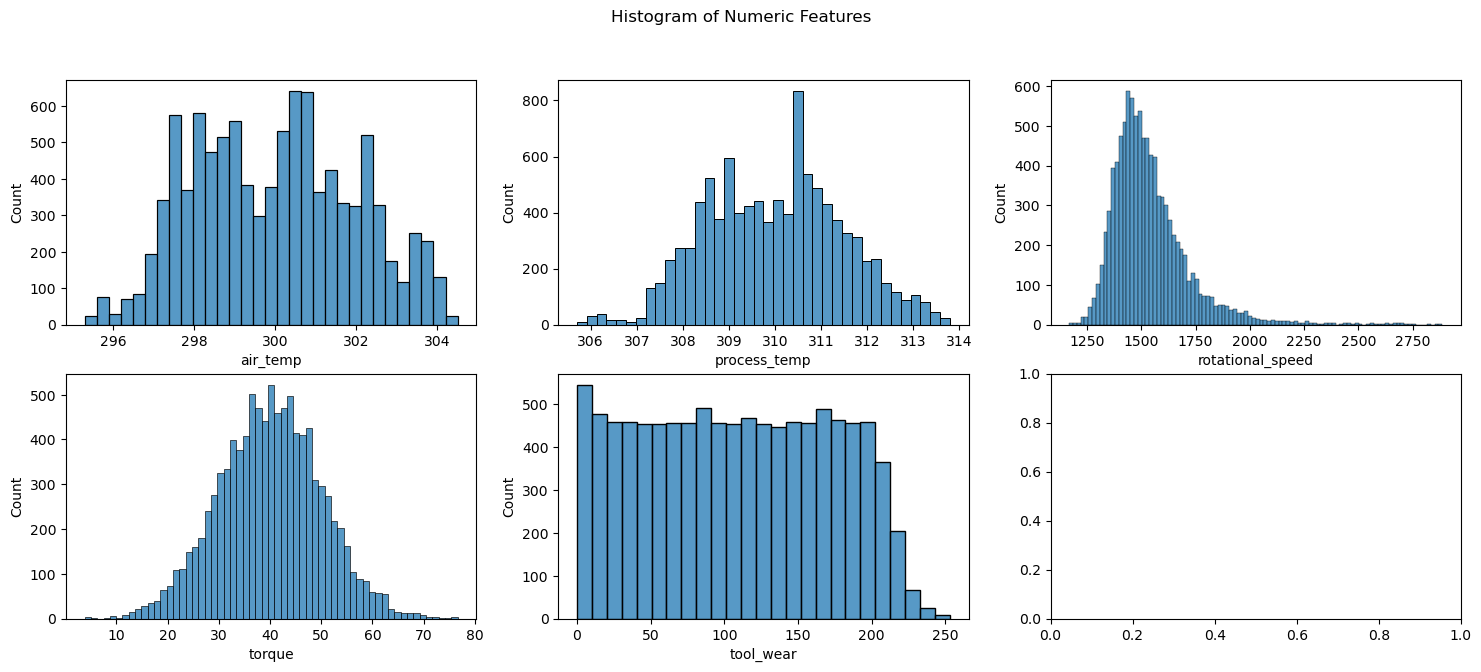

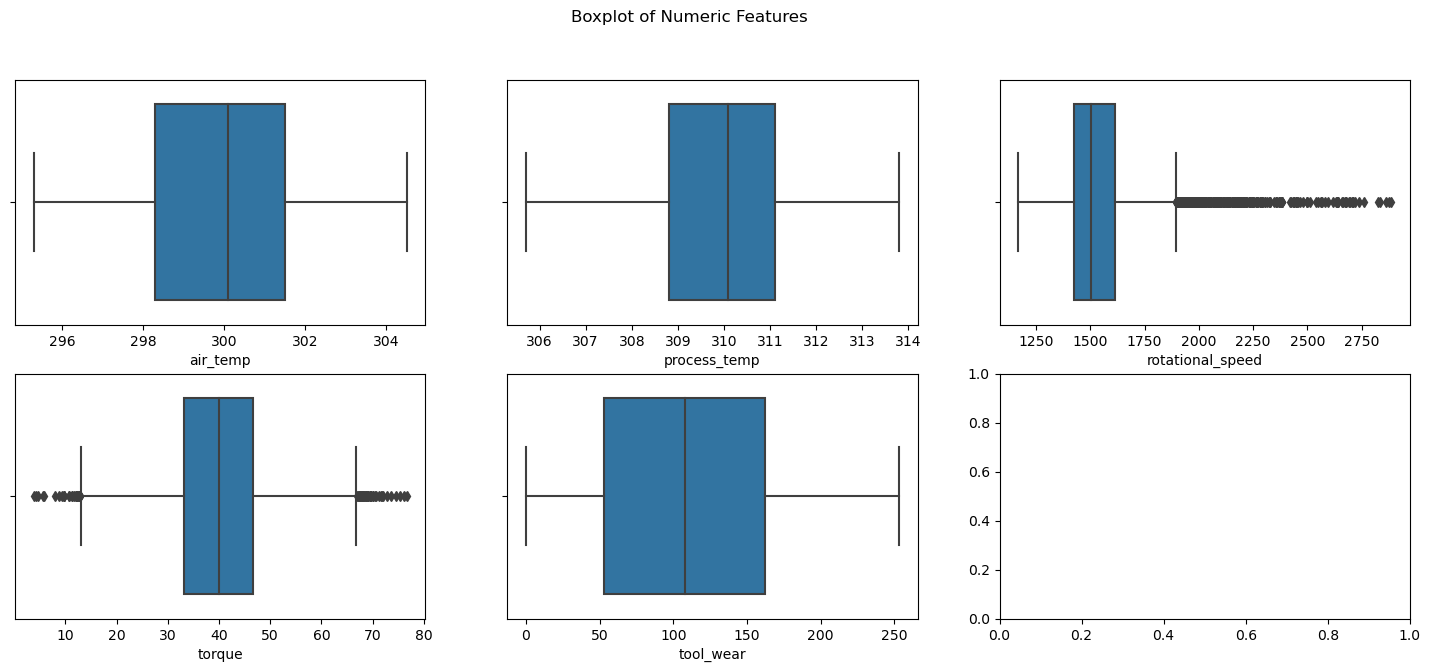

In [19]:
#checking for possible outliers
num_features = [feature for feature in features if df[feature].dtype == 'float64']

#histogram of numeric features
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(18,7))
fig.suptitle('Histogram of Numeric Features')
for a, feature in enumerate(num_features):
    sns.histplot(ax=axs[a//3, a-3*(a//3)], data=df, x=feature)
plt.show()

#boxplot of numeric features
fig, axs = plt.subplots(nrows=2, ncols = 3, figsize=(18, 7))
fig.suptitle('Boxplot of Numeric Features')
for a, feature in enumerate(num_features):
    sns.boxplot(ax = axs[a//3, a-3*(a//3)], data=df, x=feature)
plt.show()

In [20]:
#checking the percentage of failures in the dataset
df['failure_type'].value_counts()

No Failure                  9643
Heat Dissipation Failure     112
Power Failure                 95
Overstrain Failure            78
Tool Wear Failure             45
Name: failure_type, dtype: int64

In [21]:
#As seen above, there is a very low occurence of actual failures in the dataset which can lead to imbalance.
#The training model will spend most of its time on the 'no failure' data and won't learn enough from the data
#with actual failures.

Failures percentage in data: 3.31


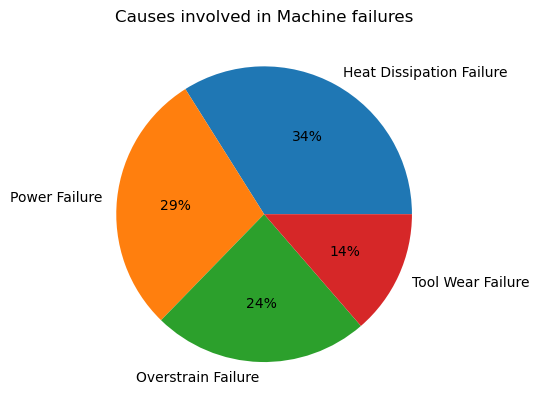

In [22]:
# Portion of df where there is a failure and causes percentage
n = df.shape[0]
idx_fail = df.loc[df['failure_type'] != 'No Failure'].index
df_fail = df.loc[idx_fail]
df_fail_percentage = 100*df_fail['failure_type'].value_counts()/df_fail['failure_type'].shape[0]
print('Failures percentage in data:',
      round(100*df['target'].sum()/n,2))
# Pie plot
plt.title('Causes involved in Machine failures')
plt.pie(x=df_fail_percentage.array, labels=df_fail_percentage.index.array,
        colors=sns.color_palette('tab10')[0:4], autopct='%.0f%%')
plt.show()

In [23]:
#handling the imbalance class by Over-Sampling with SMOTE (Synthetic Minority Oversampling Technique)
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTENC
# n_working must represent 80% of the desired length of resampled dataframe
n_working = df['failure_type'].value_counts()['No Failure']
desired_length = round(n_working/0.8)
spc = round((desired_length-n_working)/4)  #samples per class
# Resampling
balance_cause = {'No Failure':n_working,
                 'Overstrain Failure':spc,
                 'Heat Dissipation Failure':spc,
                 'Power Failure':spc,
                 'Tool Wear Failure':spc}
sm = SMOTENC(categorical_features=[0,7], sampling_strategy=balance_cause, random_state=0)
df_res, y_res = sm.fit_resample(df, df['failure_type'])

#### Features Scaling and Encoding

1. First, a label encoding is applied to the categorical columns, since type is an ordinal feature and Cause must be represented in one column. The mapping follows this scheme: Type: {L=0, M=1, H=2} Cause: {Working=0, PWF=1, OSF=2, HDF=3, TWF=4}  
2. Secondly scaling of the columns with StandardScaler is performed.

In [24]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
type_dict = {'L': 0, 'M': 1, 'H': 2}
cause_dict = {'No Failure': 0,
              'Power Failure': 1,
              'Overstrain Failure': 2,
              'Heat Dissipation Failure': 3,
              'Tool Wear Failure': 4}
df_pre = df_res.copy()
# Encoding
df_pre['type'].replace(to_replace=type_dict, inplace=True)
df_pre['failure_type'].replace(to_replace=cause_dict, inplace=True)
# Scaling
df_pre[num_features] = sc.fit_transform(df_pre[num_features]) 

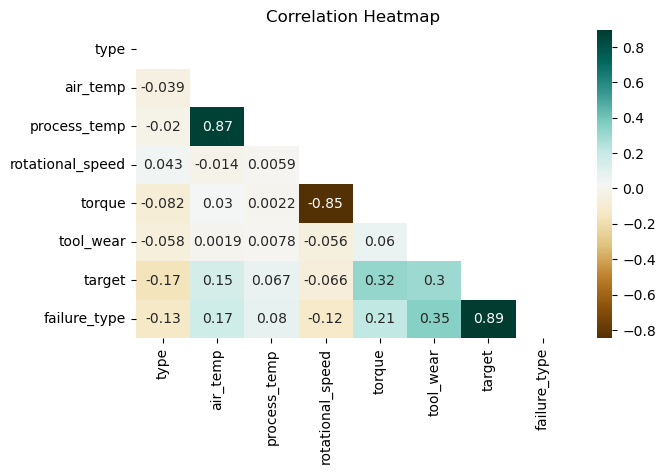

In [25]:
# Correlation Heatmap
plt.figure(figsize=(7,4))
sns.heatmap(data=df_pre.corr(), mask=np.triu(df_pre.corr()), annot=True, cmap='BrBG')
plt.title('Correlation Heatmap')
plt.show()

#### Model Generation

In [26]:
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, fbeta_score
from sklearn.metrics import confusion_matrix, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import time


# train-validation-test split
X, y = df_pre[features], df_pre[['target','failure_type']]
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.1, stratify=df_pre['failure_type'], 
                                                          random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.11, 
                                                  stratify=y_trainval['failure_type'], random_state=0)

In [27]:
def eval_preds(model,X,y_true,y_pred,task):
    if task == 'binary':
        # Extract task target
        y_true = y_true['target']
        cm = confusion_matrix(y_true, y_pred)
        # Probability of the minority class
        proba = model.predict_proba(X)[:,1]
        # Metrics
        acc = accuracy_score(y_true, y_pred)
        auc = roc_auc_score(y_true, proba)
        f1 = f1_score(y_true, y_pred, pos_label=1)
        f2 = fbeta_score(y_true, y_pred, pos_label=1, beta=2)
    elif task == 'multi_class':
        y_true = y_true['failure_type']
        cm = confusion_matrix(y_true, y_pred)
        proba = model.predict_proba(X)
        # Metrics
        acc = accuracy_score(y_true, y_pred)
        auc = roc_auc_score(y_true, proba, multi_class='ovr', average='weighted')
        f1 = f1_score(y_true, y_pred, average='weighted')
        f2 = fbeta_score(y_true, y_pred, beta=2, average='weighted')
    metrics = pd.Series(data={'ACC':acc, 'AUC':auc, 'F1':f1, 'F2':f2})
    metrics = round(metrics,3)
    return cm, metrics

In [28]:
def tune_and_fit(clf,X,y,params,task):
    if task=='binary':
        f2_scorer = make_scorer(fbeta_score, pos_label=1, beta=2)
        start_time = time.time()
        grid_model = GridSearchCV(clf, param_grid=params,
                                cv=5, scoring=f2_scorer)
        grid_model.fit(X, y['target'])
    elif task=='multi_class':
        f2_scorer = make_scorer(fbeta_score, beta=2, average='weighted')
        start_time = time.time()
        grid_model = GridSearchCV(clf, param_grid=params,
                              cv=5, scoring=f2_scorer)
        grid_model.fit(X, y['failure_type'])
        
    print('Best params:', grid_model.best_params_)
    # Print training times
    train_time = time.time()-start_time
    mins = int(train_time//60)
    print('Training time: '+str(mins)+'m '+str(round(train_time-mins*60))+'s')
    return grid_model

In [29]:
def predict_and_evaluate(fitted_models,X,y_true,clf_str,task):
    cm_dict = {key: np.nan for key in clf_str}
    metrics = pd.DataFrame(columns=clf_str)
    y_pred = pd.DataFrame(columns=clf_str)
    for fit_model, model_name in zip(fitted_models,clf_str):
        # Update predictions
        y_pred[model_name] = fit_model.predict(X)
        # Metrics
        if task == 'binary':
            cm, scores = eval_preds(fit_model,X,y_true,
                                     y_pred[model_name],task)
        elif task == 'multi_class':
            cm, scores = eval_preds(fit_model,X,y_true,
                                     y_pred[model_name],task)
        # Update Confusion matrix and metrics
        cm_dict[model_name] = cm
        metrics[model_name] = scores
    return y_pred, cm_dict, metrics

In [30]:
def fit_models(clf,clf_str,X_train,X_val,y_train,y_val):
    metrics = pd.DataFrame(columns=clf_str)
    for model, model_name in zip(clf, clf_str):
        model.fit(X_train,y_train['target'])
        y_val_pred = model.predict(X_val)
        metrics[model_name] = eval_preds(model,X_val,y_val,y_val_pred,'binary')[1]
    return metrics

In [31]:
# Models
lr = LogisticRegression()
knn = KNeighborsClassifier()
rfc = RandomForestClassifier()
 

clf = [lr,knn,rfc]
clf_str = ['LR','KNN','RFC'] 

# Fit on raw train
metrics_0 = fit_models(clf,clf_str,X_train,X_val,y_train,y_val)

# Fit on temperature product train
XX_train = X_train.drop(columns=['process_temp','air_temp'])
XX_val = X_val.drop(columns=['process_temp','air_temp'])
XX_train['temperature']= X_train['process_temp']*X_train['air_temp']
XX_val['temperature']= X_val['process_temp']-X_val['air_temp']
metrics_1 = fit_models(clf,clf_str,XX_train,XX_val,y_train,y_val)

# Fit on power product train
XX_train = X_train.drop(columns=['rotational_speed','torque'])
XX_val = X_val.drop(columns=['rotational_speed','torque'])
XX_train['power'] = X_train['rotational_speed']*X_train['torque']
XX_val['power'] = X_val['rotational_speed']*X_val['torque']     
metrics_2 = fit_models(clf,clf_str,XX_train,XX_val,y_train,y_val)

# Fit on both products train
XX_train = X_train.drop(columns=['process_temp','air_temp','rotational_speed','torque'])
XX_val = X_val.drop(columns=['process_temp','air_temp','rotational_speed','torque'])
XX_train['temperature']= X_train['process_temp']*X_train['air_temp']
XX_val['temperature']= X_val['process_temp']*X_val['air_temp']
XX_train['power'] = X_train['rotational_speed']*X_train['torque']
XX_val['power'] = X_val['rotational_speed']*X_val['torque']       
metrics_3 = fit_models(clf,clf_str,XX_train,XX_val,y_train,y_val)

Validation set metrics:
ACC    0.883
AUC    0.905
F1     0.673
F2     0.629
dtype: float64
Test set metrics:
ACC    0.881
AUC    0.917
F1     0.655
F2     0.598
dtype: float64


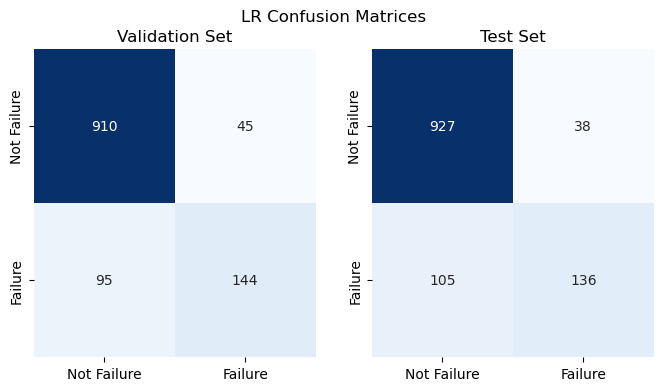

In [32]:
# Make predictions
lr = LogisticRegression(random_state=0)
lr.fit(X_train, y_train['target'])
y_val_lr = lr.predict(X_val)
y_test_lr = lr.predict(X_test)

# Metrics
cm_val_lr, metrics_val_lr = eval_preds(lr,X_val,y_val,y_val_lr,'binary')
cm_test_lr, metrics_test_lr = eval_preds(lr,X_test,y_test,y_test_lr,'binary')
print('Validation set metrics:',metrics_val_lr, sep='\n')
print('Test set metrics:',metrics_test_lr, sep='\n')

cm_labels = ['Not Failure', 'Failure']
cm_lr = [cm_val_lr, cm_test_lr]
# Show Confusion Matrices
fig, axs = plt.subplots(ncols=2, figsize=(8,4))
fig.suptitle('LR Confusion Matrices')
for j, title in enumerate(['Validation Set', 'Test Set']):
    ax = axs[j]
    sns.heatmap(ax=ax, data=cm_lr[j], annot=True,
              fmt='d', cmap='Blues', cbar=False)
    axs[j].title.set_text(title)
    axs[j].set_xticklabels(cm_labels)
    axs[j].set_yticklabels(cm_labels)
plt.show()

#### KNN and RFC

In [33]:
#models
knn = KNeighborsClassifier()
rfc = RandomForestClassifier()
clf = [knn, rfc]
clf_str = ['KNN', 'RFC']

In [34]:
# Parameter grids for GridSearch
knn_params = {'n_neighbors':[1,3,5,8,10]}
rfc_params = {'n_estimators':[100,300,500,700],
              'max_depth':[5,7,10],
              'random_state':[0]}
params = pd.Series(data=[knn_params,rfc_params],
                   index=clf)

In [35]:
# Tune hyperparameters with GridSearch
print('GridSearch start')
fitted_models_binary = []
for model, model_name in zip(clf, clf_str):
    print('Training '+str(model_name))
    fit_model = tune_and_fit(model,X_train,y_train,params[model],'binary')
    fitted_models_binary.append(fit_model)

GridSearch start
Training KNN
Best params: {'n_neighbors': 1}
Training time: 0m 2s
Training RFC
Best params: {'max_depth': 10, 'n_estimators': 500, 'random_state': 0}
Training time: 1m 41s


In [36]:
# Create evaluation metrics
task = 'binary'
y_pred_val, cm_dict_val, metrics_val = predict_and_evaluate(
    fitted_models_binary,X_val,y_val,clf_str,task)
y_pred_test, cm_dict_test, metrics_test = predict_and_evaluate(
    fitted_models_binary,X_test,y_test,clf_str,task)

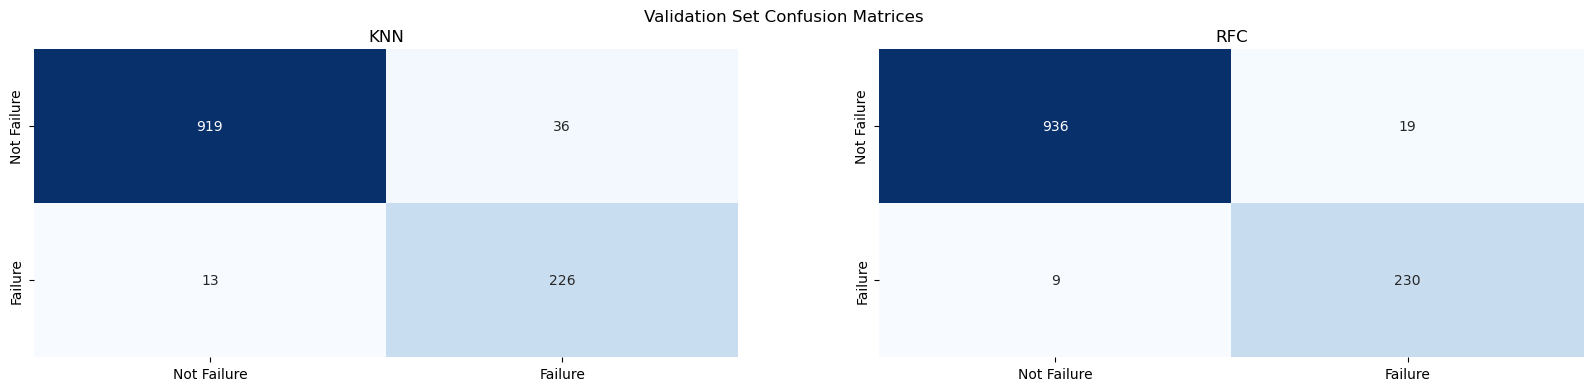

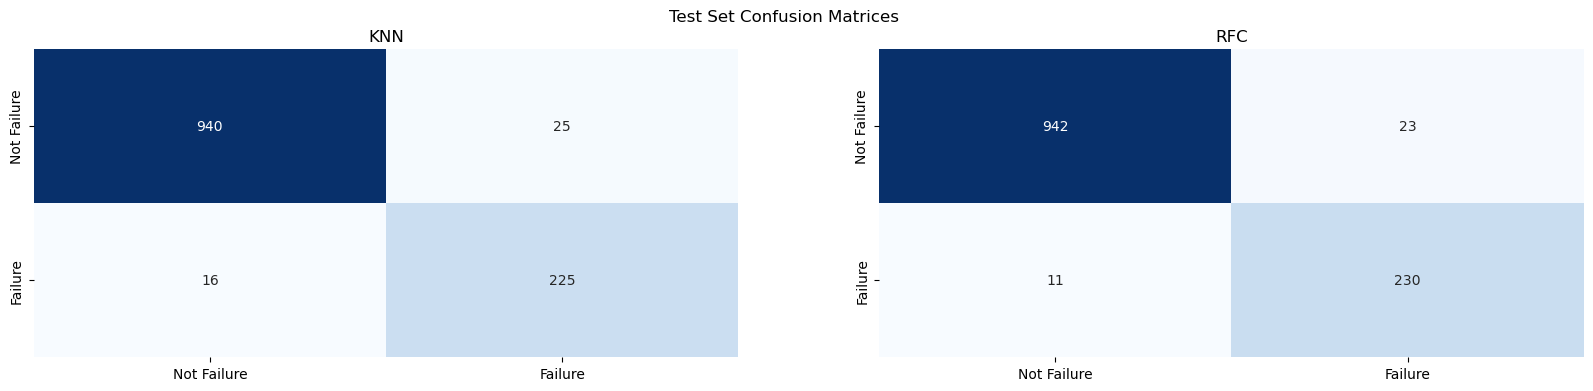


Validation scores:
       KNN    RFC
ACC  0.959  0.977
AUC  0.954  0.997
F1   0.902  0.943
F2   0.928  0.954
Test scores:
       KNN    RFC
ACC  0.966  0.972
AUC  0.954  0.997
F1   0.916  0.931
F2   0.927  0.945


In [37]:
# Show Validation Confusion Matrices
fig, axs = plt.subplots(ncols=2, figsize=(20,4))
fig.suptitle('Validation Set Confusion Matrices')
for j, model_name in enumerate(clf_str):
    ax = axs[j]
    sns.heatmap(ax=ax, data=cm_dict_val[model_name], annot=True,
                fmt='d', cmap='Blues', cbar=False)
    ax.title.set_text(model_name)
    ax.set_xticklabels(cm_labels)
    ax.set_yticklabels(cm_labels)
plt.show()

# Show Test Confusion Matrices
fig, axs = plt.subplots(ncols=2, figsize=(20,4))
fig.suptitle('Test Set Confusion Matrices')
for j, model_name in enumerate(clf_str):
    ax = axs[j]
    sns.heatmap(ax=ax, data=cm_dict_test[model_name], annot=True,
                fmt='d', cmap='Blues', cbar=False)
    ax.title.set_text(model_name)
    ax.set_xticklabels(cm_labels)
    ax.set_yticklabels(cm_labels)
plt.show()

# Print scores
print('')
print('Validation scores:', metrics_val, sep='\n')
print('Test scores:', metrics_test, sep='\n')